In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import scipy.stats as stats

# INF 554 Lab 3: Unsupervised Learning

In Lab 2 we worked with supervised classifcation methods where training data points were labelled and we were able to use these labels to train our models. When class labels are not available to us then we utilise unsupervised learning methods, which do not rely on known class labels.

In this lab we will work with two unsupervised learning algorithms, namely the $K$-means algorithm and the Expectation Maximisation algorithm to fit a Gaussian Mixture Model. Both of these methods are known as _clustering algorithms_ because they label each data point with a discrete label corresponding to a cluster detected in the data. 

Besides the split into supervised and unsupervised learning methods, statistical methods can be split into _non-parametric and parametric methods_. The $K$-means algorithm is a non-parametric method, meaning that the $K$-means algorithm makes no distributional assumptions on the data. In contrast, the use of Gaussian Mixture Models for clustering is a parametric method, since it is based on the assumption that our data can be modeled by a mixture of Gaussian distributions, the parameters of which we infer. 



## K-means

Let $\{x_1, \dots, x_n\}$ be a set of $n$ data points. The $K$-means algorithm aims to cluster the datapoints into $K$ clusters, where the number of clusters $K$ is an input of the algorithm. The $K$-means objective function is equal to the following,
\begin{equation} \label{eq:kmeans_objective}
\underset{(C_1, \ldots, C_K)}{\text{argmin}} \sum_{j=1}^K \sum_{i \in C_j} \|x_i - c_j\|^2, \hspace{1.5cm}(1)
\end{equation}

where $\{c_1, \ldots, c_K\}$ denote the centroids of the $K$ clusters denoted $\{C_1, \ldots, C_K\}$.This objective function is solved using an iterative algorithm, where the following two steps take part at each iteration: (i) take each instance belonging  to the dataset and assign it to the nearest centroid, and (ii)  re-calculate  the centroids  of  each of the $K$  clusters. Thus, the $K$ centroids change their location step by step until no more changes are done.




In this lab we work with simulated data which is drawn from several Gaussian distributions with different means and variances. We provide you with the $\texttt{generate}$_$\texttt{data}$ function to sample this data.





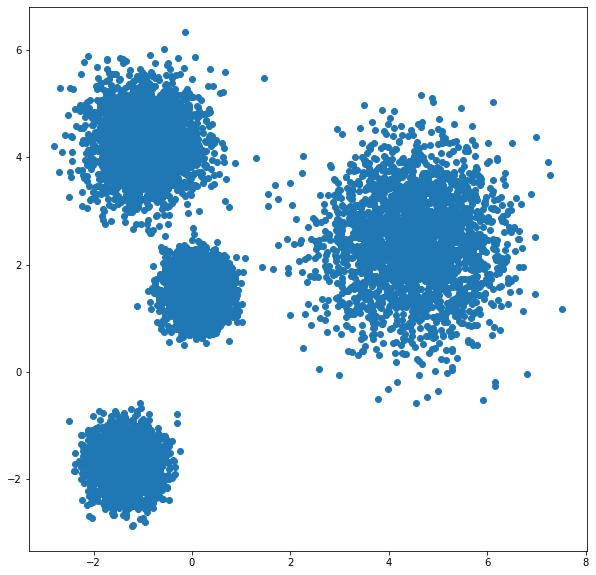

In [2]:
np.random.seed(2604)


def generate_data(n_clusters, n_dim, n_data):
    """
    Args:
        n_clusters (int): the number of clusters
        n_dim (int): data dimensionality
        n_data (int): number of data points (split evenly into clusters)
    Returns:
        X (np.array(n_data, n_dim)): data  
    """
    mus = np.random.uniform(-5, 5, size=(n_clusters,n_dim))
    sigmas = np.random.uniform(-0.7, 0.7, size=(n_clusters,n_dim))
    X = []
    for k in range(n_clusters):    
        X.append(np.random.normal(mus[k,:],sigmas[k,:] @ sigmas[k,:].T,size=(int(n_data/n_clusters),n_dim)))

    return  np.concatenate([X]).reshape(-1,n_dim)


X = generate_data(n_clusters=4, n_dim=2, n_data=10000)


plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1])
plt.show()

We will now consider two possible centroid initialisation schemes for the $K$-means algorithm. 

Firstly, in the standard $K$-means algorithm cluster centroids are initialised at random datapoints in our dataset.

Secondly, in the improved $K$-means++ algorithm the centroids are sampled one by one with the first centroid being chosen at a random data point. Further, if we let $d_i$ denote the Euclidean distance of datapoint $x_i$ to its closest, already sampled, centroid, then the probability of data point $x_i$ being chosen as the next centroid is equal to $\frac{d_i^2}{\sum_{i=1}^n d_i^2}.$ 

>**Task 1**: Implement the $K$-means++ initialisation scheme and visually compare its output with the random initialisation scheme in the below plot. (Hint: you can make use of ```np.random.multinomial``` to sample the index of the next centroid in the $K$-means++ initialisation scheme. )

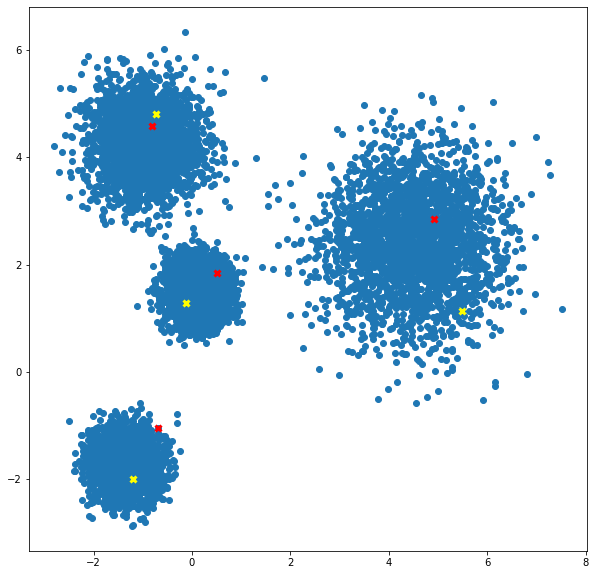

In [3]:
def random_initialisation(X,K):
    """
    Args:
        X (np.array(N,d)): data. 
        K (int): The number of clusters
    Returns:
        c (np.array(K,d)): matrix containing the randomly initialised cluster centeres 
    """
    
    N = X.shape[0]
    
    #initialisation
    initial_indices = np.random.choice(np.arange(N), size=K, replace=False)
    c = X[initial_indices, :]
    
    return c
    

def kmeans_plusplus_initialisation(X,K):
    """
    Args:
        X (np.array(N,d)): data. 
        K (int): The number of clusters
    Returns:
        c (np.array(K,d)): matrix containing the k-means++ initialised cluster centeres 
    """
    
    N,d = X.shape
    
    c = np.zeros((K,d))
    
    initial_index = np.random.choice(np.arange(N), size=1, replace=False)
    c[0,:] = X[initial_index, :]
    
    
    # Please insert the code for Task 1 here
    
    distance_to_centroids = np.zeros((N,K-1))

    for k in range(K-1):
        distance_to_centroids[:,k] = np.linalg.norm(X-c[k,:], axis=1)
        
        distance_to_closest_centroid = np.min(distance_to_centroids[:,:k+1], axis=1)
        sq_distance_to_closest_centroid = distance_to_closest_centroid**2
        
        sampling_probabilities = sq_distance_to_closest_centroid/np.sum(sq_distance_to_closest_centroid)
        
        next_index = np.random.multinomial(1, sampling_probabilities)
        c[k+1,:] = X[np.where(next_index==1), :]
        
    return c
        
        
c_random = random_initialisation(X,4)
c_plus_plus = kmeans_plusplus_initialisation(X,4)


plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:,1])
plt.scatter(c_random[:,0].reshape(-1), c_random[:,1].reshape(-1), c='red', marker='x', linewidths=3)
plt.scatter(c_plus_plus[:,0].reshape(-1), c_plus_plus[:,1].reshape(-1), c='yellow', marker='x', linewidths=3)
plt.show()


>**Task 2**: Implement the $K$-means clustering algorithm.

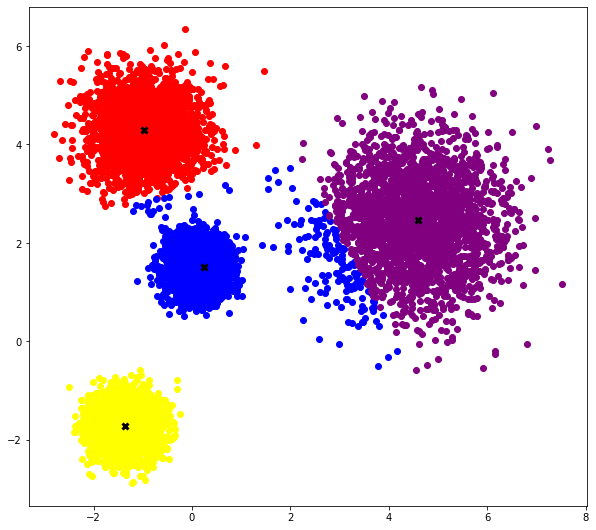

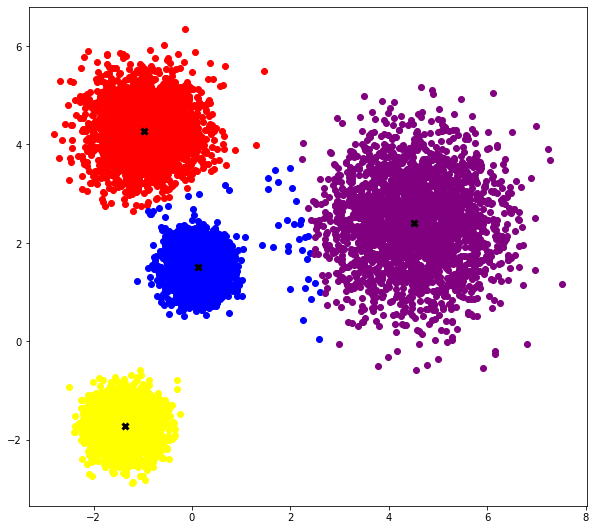

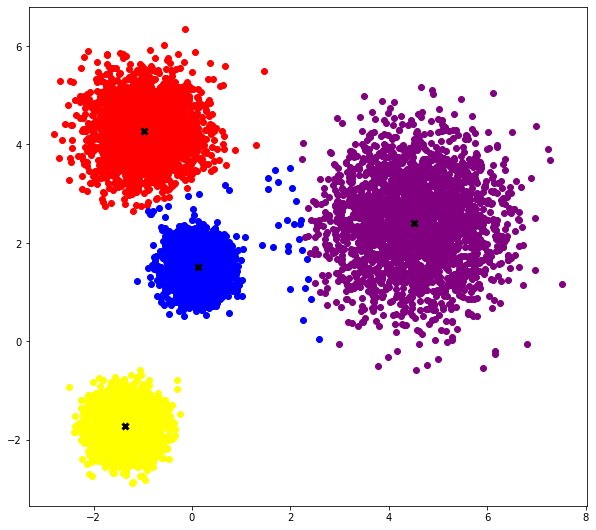

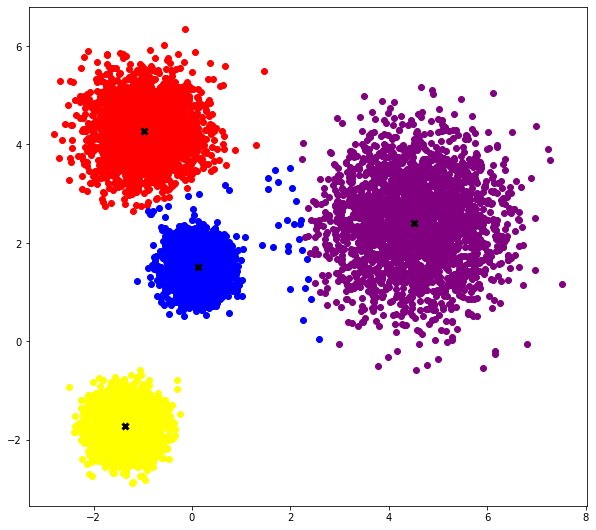

In [4]:
def plot_Kmeans(X, c, S):
    clusters_col = ["red", "blue", "yellow", "purple", "black", "green", "cyan"] 
    fig, a = plt.subplots(subplot_kw={'aspect': 'equal'}, figsize=(10,10))
    for j in range(K):
        x1 = [X[i,0] for i in range(X.shape[0]) if S[i,j]==1]
        x2 = [X[i,1] for i in range(X.shape[0]) if S[i,j]==1]
        a.scatter(x1,x2, c=clusters_col[j])
    a.scatter(c[:,0].reshape(-1), c[:,1].reshape(-1), c='black', marker='x', linewidths=3)
    plt.show()

    
    
    
def K_means(X, K, initialisation, E=10**(-8), visualise=True):
    """
    Args:
        X (np.array(N,d)): data. 
        K (int): The number of clusters
        E (float): acceptable margin of error for the stopping rule
        visualise (boolean): indicator of whether the progression of the k-means algorithm should be plotted
    Returns:
        c (np.array(K,d)): matrix containing the cluster centeres 
        S (np.array(N,K)): binary matrix containing 1-hot encodings of the cluster membership 
    """
    
    
    
    if initialisation == 'random':
        c = random_initialisation(X,K)
        
    elif initialisation == 'plusplus':
        c = kmeans_plusplus_initialisation(X,K)
        
    else:
        raise ValueError("Please specify a valid initialisation scheme ('random' or 'plusplus').")
    
    N = X.shape[0]
    c_temp = c+2*E
        
    
    while(np.abs(np.mean(c-c_temp))>E):
        
        # Please insert the code for Task 2 here        
        dists = np.zeros((N,K))
        for k in range(K):
            dists[:,k] = np.linalg.norm(X-c[k,:], axis=1)
        
        #step(1)
        cluster_membership = np.argmin(dists, axis=1)
        S = np.zeros((N,K))
        for i in range(N):
            S[i,cluster_membership[i]] = 1
    
        #step(2)
        c_temp = c
        c = S.T@X/ np.sum(S,0).reshape(-1,1)    
        
        if visualise == True:
            plot_Kmeans(X, c, S)
    
    return c, S

K=4
c,S = K_means(X,K, 'plusplus')


>**Task 3**: For $K\in \{1,\ldots,8\}$ please run the standard $K$-means and the $K$-means++ algorithm 10 times each and log their final objective values computed according to Equation (1). Then, for each $K$ compute the mean objective value over all 10 runs for both algorithms and plot them against the parameter $K.$ (Please store the values obtained for the standard initialisation in the first row of $\texttt{SSW}$\_$\texttt{temp}$ and the values obtained for the $K$-means++ initialisation in the second row of $\texttt{SSW}$\_$\texttt{temp}$.) 


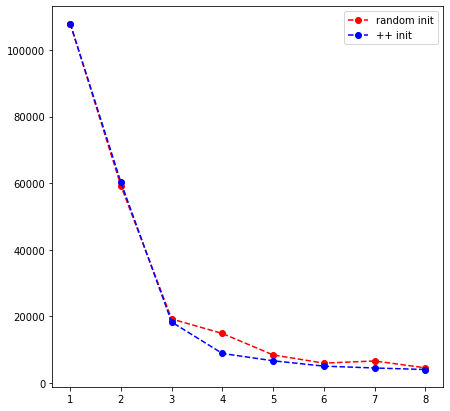

In [5]:
def Elbow(X, k_max, E, repetitions):
    """
    Args:
        X (np.array(N,d)): data. 
        k_max (int): the numbers of clusters up to which we calculate the objective function
        E (float): acceptable margin of error for the K-Means stopping rule
        repetitions (int): Number of clusterings over which we average the final objective values
    Returns:
        SSW_standard (np.array(k_max)): The average of the final objective values for the obtained clusterings
                                 of the standard K-means algorithm
        SSW_plusplus (np.array(k_max)): The average of the final objective values for the obtained clusterings
                                 of the K-means++ algorithm
    """
    
    SSW_standard = np.zeros(k_max)
    SSW_plusplus = np.zeros(k_max)
    
    for j in range(1, k_max+1):
        SSW_temp = np.zeros((2, repetitions))
        for rep in range(repetitions):
            for init in ['random', 'plusplus']:
                
                # Please insert the code for Task 3 here 
                
                c,S = K_means(X, j, init, visualise=False)
                SSW_temp[int(init=='plusplus'),rep] = np.sum(np.linalg.norm(X - S@c, axis=1)**2)
        
        SSW_standard[j-1] = np.mean(SSW_temp[0,:])
        SSW_plusplus[j-1] = np.mean(SSW_temp[1,:])
    
    
    return SSW_standard, SSW_plusplus

K_max = 8
SSW_standard, SSW_plusplus = Elbow(X, K_max, 10**(-5), 10)

fig = plt.figure(figsize=(7,7))
plt.plot(np.arange(K_max)+1, SSW_standard, 'o--', c='r')
plt.plot(np.arange(K_max)+1, SSW_plusplus, 'o--', c='b')
plt.legend(['random init', '++ init'])
plt.show()

>**Question 1**: Can you think of a reasonable heuristic to choose the number of clusters $K$ in the $K$-means algorithm based on  the plot created in Task 2.

>**Question 2**: In which scenarios do you think will the $K$-means algorithm fail to identify sensible clusters in clustered data.

## Gaussian Mixture Models (GMMs)


In this part of the lab we will use the Expectation Maximisation (EM) algorithm to fit a Gaussian Mixture Model to our data. 

The Gaussian mixture model has the form,
$$
f(x|\theta) = \sum_{i=1}^K w_i \phi(x| \mu_i, \Sigma_i),
$$
where $\phi$ denotes the multivariate Gaussian distribution and $\theta$ contains the means $\mu_1, \ldots, \mu_K,$ the covariance matrices $\Sigma_1, \ldots, \Sigma_K$ and the mixing proportions $w_1, \ldots, w_K,$ i.e., $\theta =(\mu_1. \ldots, \mu_K, \Sigma_1, \ldots, \Sigma_K, w_1, \ldots, w_K).$

Recall that the density of a multivariate Gaussian distribution with $d$ dimensions has the following functional form 
\begin{equation}
	\phi(x|\mu, \Sigma) = \frac{1}{\sqrt[]{2\pi}^d \det(\Sigma)^{1/2}} \exp\Big[-\frac{1}{2}(x-\mu)^\top \Sigma^{-1} (x-\mu)\Big].
\end{equation}


Direct maximisation of the log likelihood of the Gaussian mixture distribution is numerically very difficult. A simpler approach is to  introduce an unobserved latent variable $Z$ into the model, which encodes cluster membership. Using $Z$ the Gaussian mixture model can be rexpressed as follows,
$$
f(x|\theta, Z=k) = \phi(x| \mu_k, \Sigma_k)
$$
and 
$$
P(Z=k|\theta)=w_k.
$$


Once the Gaussian Mixture model is fitted to our data, i.e., we have parameter estimates $\hat{\theta},$ we can use it  to make cluster membership predictions by calculating $P(Z_i=k|x_i, \hat{\theta}).$


>**Question 3**: Derive the analytical expressions of the Expectation and the Maximisation steps to fit the Gaussian Mixture model by following the steps below.  
> 1. The likelihood of the Gaussian Mixture Model is defined to be $L(x, Z; \theta) = P(x, Z|\theta).$ Derive the log likelihood of the Gaussian Mixture model to be $$l(x, Z; \theta) = \sum_{i=1}^N \sum_{k=1}^K \text{Ind}\{Z_i=k\}\Big[\ln w_k + \ln \phi(x_i|\mu_k,\Sigma_k)\Big]$$

> 2. Take the expectation of the log likelihood derived in 1. with respect to the distribution of $P(Z|x, \theta_t)$ to obtain$$ E_{Z|x,\theta_t}\left[l(x, Z;\theta)\right] = \sum_{i=1}^N \sum_{k=1}^K \gamma_{ik}(\theta_t)\Big[\ln w_k + \ln \phi(x_i|\mu_k,\Sigma_k)\Big],$$ where $$\gamma_{ik}(\theta) = \frac{w_k \phi(x_i|\mu_k. \Sigma_k)}{\sum_{j=1}^Kw_{j} \phi(x_i|\mu_{j}. \Sigma_{j})}.$$ In the context of Gaussian Mixture models $\gamma_{ik}(\theta)$ is called the *responsibility* of the normal distribution $k$ for data point $x_i$.

> 3. Maximise the expectation from 2. with respect to $\mu_k,$ $\Sigma_k$ and $w_k.$ The maxmisation with respect to  $\mu_k$ and $\Sigma_k$ can be achieved by taking the derivative as we did in the previous labs. However, for the maximisation with respect to $w_k$ you need to use a Lagrange multiplier to take the constraint $\sum_{i=1}^K w_k = 1$ into acccount. When taking these derivates it is crucial to note that in the expectation step we had the parameters from the previous iteration $\theta_t$ given, which are known constants. Therefore, $\theta_t$ takes the role of a constant when differentiating with respect to $\mu_k,$ $\Sigma_k$ and $w_k.$ 




>**Task 4**: Implement the expectation step by completing the function below. Specifically, we require you to fill in the computation of the responsibilities $\gamma_{ik}(\theta)$ in the function ```compute_gammas```.

In [6]:
def norm_density(x, mu, det_sigma, inv_sigma):
    """
    Args:
        x (np.array): a data point
        mu (np.array): a mean vector
        det_sigma (float): determinant of variance matrix
        inv_sigma (np.array): inverse of variance matrix
    returns:
        (float)
    """
    
    deviation = (x-mu).T
    return (1/(np.sqrt(2*np.pi)**len(x) * det_sigma) * np.exp(-1/2*deviation.T @ inv_sigma @ deviation)).item()

def compute_gammas(X, w, mus, sigmas):
    """
    Args:
        X (np.array): Full data (n_data, dimensions)
        w (iterable): the probbilities associated with the clusters
        mus (np.array): mean vectors of clusters (n_clusters, dimensions)
        sigmas (np.array): variance matrices of the clusters (n_clusters, dimensions, dimensions)
    Returns:
        gammas (np.array): matrix of gammas product of the expectation step (n_clusters, n_data)
    """
    n_clusters = len(w)
    # First we compute inverses and determinants, so that we don't loose computation time
    inv_sigma = []
    det_sigma = []
    for k in range(n_clusters):
        inv_sigma.append(np.linalg.inv(sigmas[k,:,:]))
        det_sigma.append(np.linalg.det(sigmas[k,:,:]))
        
    gammas = np.array(np.zeros(shape=(n_clusters, X.shape[0])))
    for k in range(n_clusters):
        for i in range(X.shape[0]):
            densities = np.array([norm_density(X[i,:], mus[j,:], det_sigma[j], inv_sigma[j]) for j in range(n_clusters)])
            gammas[k,i] = w[k]*densities[k]/(w.T@densities)    # Please insert the code for Task 4 here 
    return gammas

>**Task 5**: Implement the Maximisation step by completing the three functions below. Specifically, we require you to fill in the maximum expected likelihood estimators dervied in Question 3.3 in the functions  ```w_update```, ```mu_update``` and ```sigma_update```.

In [7]:
def w_update(gammas_sum, n_data):
    """
    Args:
        gammas_sum (np.array): vector containing the sum of gammas (n_clusters)
        n_data (int): number of data points
    Returns:
        w (np.array): the updated probbilities associated with the clusters
    """
    return gammas_sum/n_data    # Please insert the code for Task 5 here 

def mu_update(gammas_sum, gammas, X):
    """
    Args:
        gammas_sum (np.array): vector containing the sum of gammas (n_clusters)
        gammas (np.array): matrix of gammas product of the expectation step (n_clusters, n_data)
        X (np.array): Full data (n_data, dimensions)
    Returns:
        mus (np.array): updated mean vectors of clusters (n_clusters, dimensions)
    """
    return  (gammas@X)/gammas_sum   # Please insert the code for Task 5 here 

def sigma_update(gammas, gammas_sum, X, mus):
    """
    Args:
        gammas_sum (np.array): vector containing the sum of gammas (n_clusters)
        gammas (np.array): matrix of gammas product of the expectation step (n_clusters, n_data)
        X (np.array): Full data (n_data, dimensions)
    Returns:
        sigmas (np.array): variance matrices of the clusters (n_clusters, dimensions, dimensions)
    """
    n_clusters = mus.shape[0]
    sigmas = np.zeros(shape=(n_clusters, X.shape[1], X.shape[1]))
        
    # Please insert the code for Task 5 here 
    for k in range(n_clusters):
        deviations = X-mus[k,:]
        sigmas[k, :, :] = (np.expand_dims(gammas[k,:].T,axis=1) * deviations).T @ deviations/gammas_sum[k]
    return sigmas

Below we have implemented the $\texttt{EM}$ function, which combines your expectation and maximisation functions to fit a Gaussian Mixture Model to the data.

In [8]:
def EM(data, n_dimensions, n_clusters, n_steps):
    """
    Args:
        data (np.array): (n_data, dimensions)
        n_dimensions (int): number of dimensions to use
        n_clusters (int)
        n_steps (int)
    Returns:
        mus (np.array): mean vectors of clusters (n_clusters, dimensions)
        sigmas (np.array): variance matrices of the clusters (n_clusters, dimensions, dimensions)
        w (np.array): probabilities associated with the clusters
    """
    # Init X and parameters
    X = np.array(data[:,:n_dimensions])
    n_data = X.shape[0]
    mus = np.random.normal(0, 1, size=(n_clusters, n_dimensions))
    sigmas = np.stack([np.identity(n_dimensions)]*n_clusters)
    w = np.random.uniform(0, 1, size=n_clusters)
    w /= np.sum(w)
    
    for step in range(n_steps):
        #Expectation
        gammas = compute_gammas(X, w, mus, sigmas)
        #Maximization
        gammas_sum = np.sum(gammas, 1).reshape(-1,1)
        w = w_update(gammas_sum, n_data)
        sigmas = sigma_update(gammas, gammas_sum, X, mus)
        mus = mu_update(gammas_sum, gammas, X)

    return np.array(mus), sigmas, w

Evaluate your EM algorithm on 1-dimensional and 2-dimensional data samples obtained from the $\texttt{generate}$_$\texttt{data}$ function and assess by visual observation whether the fixed distributions fit the data well.

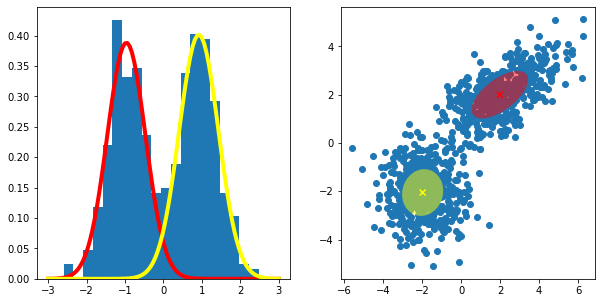

In [9]:
np.random.seed(2604)

def generate_data_GMM(n_clusters, n_dim, n_data, mus, sigmas):
    """    
    Args:
        n_clusters (int): the number of clusters
        n_dim (int): data dimensionality
        n_data (int): number of data points (split evenly into clusters)
        mus (list): list of  means, can be ints of lists, depending on
                    dimensionality. If int for multivariate data, all
                    dimensions have same mean.
        sigmas (list): A list of variances, can be int, or matrix
    Returns:
        X (np.array(n_data, n_dim)): data  
    """

    X_ = []

    for mu, sigma in zip(mus, sigmas):
        if np.shape(sigma) == (n_dim, n_dim):
            if not isinstance(mu, list):
                mu = [mu for _ in range(n_dim)]

            X_.append(np.random.multivariate_normal(mu,sigma,size=int(n_data/n_clusters)))
        else:
            X_.append(np.random.normal(mu,sigma,size=(int(n_data/n_clusters),n_dim)))

    return  np.concatenate([X_]).reshape(-1,n_dim)

# 1-d test:

X = generate_data_GMM(n_clusters=2, mus=[-1,1], sigmas=[0.5,0.5], n_dim=1, n_data=500)
mus, sigmas, w = EM(X, n_dimensions=1, n_clusters=2, n_steps=30) 
n_clusters = mus.shape[0]


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5)) #plt.figure(figsize=(7,5))
clusters_col = ["red", "yellow", "green", "black"] 
ax1.hist(X, 20, density=True)
x = np.linspace(-3,3,100)
for k in range(n_clusters):
    ax1.plot(x, w[k,0]*stats.norm.pdf(x, mus[k].item(), np.sqrt(sigmas[k].item())),
             linewidth = 4, color=clusters_col[k])



# 2-d test:

True_Sigma_1 = 1
True_Sigma_2 = np.array([[2, 0.9], [0.9, 1]])
X = generate_data_GMM(n_clusters=2, mus=[-2,2], sigmas=[True_Sigma_1, True_Sigma_2], 
                  n_dim=2, n_data=1000)

mus, sigmas, w = EM(X, n_dimensions=2, n_clusters=2, n_steps=30)



zoom = 2
n_clusters = mus.shape[0]

ax2.scatter(X[:,0], X[:,1])
ax2.scatter(mus[:,0].reshape(-1), mus[:,1].reshape(-1), 
          c=clusters_col[:n_clusters], marker='x')
    
    
    
for k in range(n_clusters):
    u, v = np.linalg.eig(sigmas[k,:,:])
    e = Ellipse(xy=tuple(mus[k,:]),
            width=2*np.sqrt(u[0]), 
            height=2*np.sqrt(u[1]),
            angle=180/np.pi * np.arccos((v[0,:].T @ np.matrix([[1,0]]).T).item()/ (np.linalg.norm(v[:,0]))))#-np.arctan(v[0,1]/v[0,0])* 180/np.pi)#
    e.set_clip_box(ax2.bbox)
    e.set_alpha(float(w[k]))
    e.set_facecolor(clusters_col[k])
    ax2.add_artist(e)